-----------------------
# <font color='blue'>**Time Series - LSTM + CNN** </font>
-----------------------

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_series, plot_series_2, trend, seasonal_pattern
from utils import seasonality, noise, generate_synthetic_timeseries
from utils import windowed_dataset, model_forecast

ImportError: cannot import name 'plot_series_2' from 'utils' (g:\My Drive\Study\Tensorflow\TensorFlow-in-practice-Coursera-DeeplearningAI\utils.py)

#### <font color='magenta'> 1) Generating Synthetic Data </font>

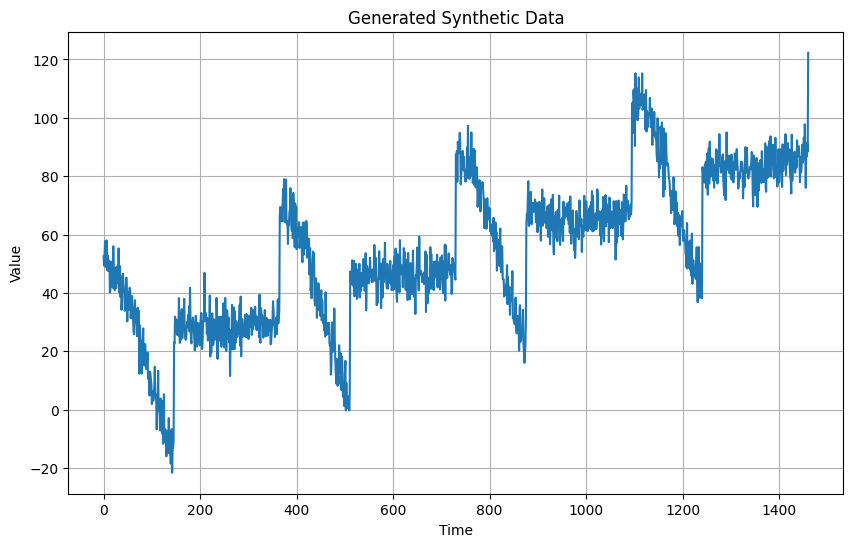

In [3]:
series, time = generate_synthetic_timeseries()
plot_series(time, series, title='Generated Synthetic Data')

#### <font color='magenta'> 2) Splitting the Dataset </font>

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

#### <font color='magenta'> 3) Preparing features and labels </font>

In [5]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#### <font color='magenta'>4) Build the Model </font>

Here is the model architecture you will be using. It is very similar to the last RNN you built but with the [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer at the input. One important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) here is the `padding`. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [6]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


#### <font color='magenta'> 5) Tuning the Learning Rate </font>

In the previous labs, we are using different models for tuning and training. 

That is a valid approach but we can also use the same model for both. 

Before tuning, we can use the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method so that we can reset it later.

In [7]:
# Get initial weights
init_weights = model.get_weights()



# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 [==============================] - 11s 17ms/step - loss: 28.6110 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 1s 12ms/step - loss: 18.4189 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 1s 12ms/step - loss: 15.8421 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 14.1088 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 1s 11ms/step - loss: 12.6532 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 1s 12ms/step - loss: 11.5754 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 1s 11ms/step - loss: 10.8643 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 1s 11ms/step - loss: 10.3969 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 1s 12ms/step - loss: 10.1053 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 1s 12ms/step - loss: 9.8889 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 50.0)

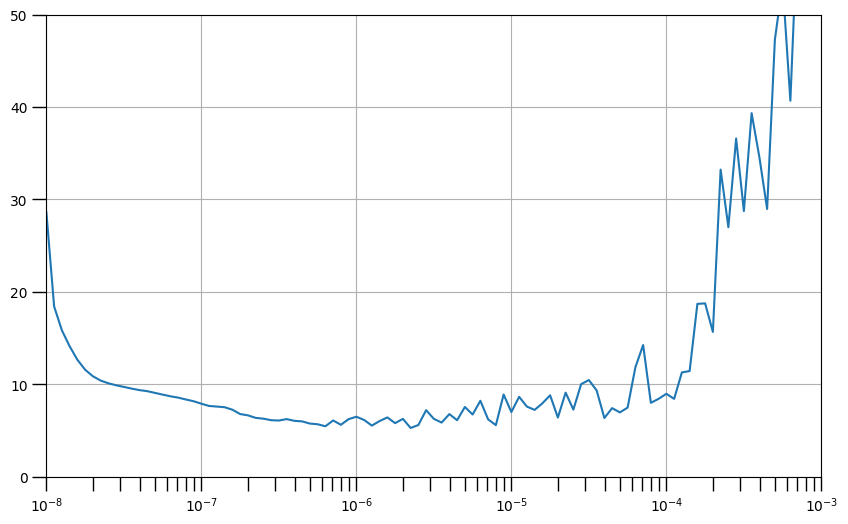

In [8]:
# Plotting the Learning Rate Curve
# --------------------------------
lrs = 1e-8 * (10 ** (np.arange(100) / 20))          # Define the learning rate array
plt.figure(figsize=(10, 6))                         # Set the figure size
plt.grid(True)                                      # Set the grid
plt.semilogx(lrs, history.history["loss"])          # Plot the loss in log scale
plt.tick_params('both', length=10, width=1, which='both')       # Increase the tickmarks size
plt.axis([1e-8, 1e-3, 0, 50])                       # Set the plot boundaries

#### <font color='magenta'> 6) Training the Model </font>

In [9]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)


# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=500)

Epoch 1/500
62/62 [==============================] - 4s 17ms/step - loss: 17.2968 - mae: 17.7877
Epoch 2/500
62/62 [==============================] - 1s 14ms/step - loss: 10.2116 - mae: 10.6948
Epoch 3/500
62/62 [==============================] - 1s 12ms/step - loss: 9.4935 - mae: 9.9735
Epoch 4/500
62/62 [==============================] - 1s 11ms/step - loss: 9.1838 - mae: 9.6649
Epoch 5/500
62/62 [==============================] - 1s 14ms/step - loss: 8.8616 - mae: 9.3401
Epoch 6/500
62/62 [==============================] - 1s 13ms/step - loss: 8.5959 - mae: 9.0773
Epoch 7/500
62/62 [==============================] - 1s 13ms/step - loss: 8.2220 - mae: 8.6996
Epoch 8/500
62/62 [==============================] - 1s 13ms/step - loss: 8.0016 - mae: 8.4802
Epoch 9/500
62/62 [==============================] - 1s 14ms/step - loss: 7.7840 - mae: 8.2626
Epoch 10/500
62/62 [==============================] - 1s 13ms/step - loss: 7.5375 - mae: 8.0187
Epoch 11/500
62/62 [=========================

Training can be a bit unstable especially as the weights start to converge so we may want to visualize it to see if it is still trending down. 

The earlier epochs might dominate the graph so it's also good to zoom in on the later parts of training to properly observe the parameters. 

The code below visualizes the `mae` and `loss` for all epochs, and also zooms in at the last 80%.

In [10]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

TypeError: plot_series() got an unexpected keyword argument 'x'

#### <font color='magenta'> 7) Predicting from the Model </font>

#### <font color='magenta'> 8) Adding callback for early stopping </font>